<a href="https://colab.research.google.com/github/bokutachi256/gisday2019/blob/master/1_%E5%9F%BA%E7%9B%A4%E5%9C%B0%E5%9B%B3%E6%83%85%E5%A0%B1%E3%81%AE%E8%AA%AD%E3%81%BF%E8%BE%BC%E3%81%BF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 基盤地図情報の読み込み


* GIS Day in 東京 2019 Eコース
* Pythonを用いたDEM処理
* 首都大学東京 都市環境学部 地理環境学科 中山大地
* 2019年12月21日 首都大学東京 南大沢キャンパス
* [github repository: www.github.com/bokutachi256/gisday2019](https://www.github.com/bokutachi256/gisday2019)
* 更新履歴
  - 2021年6月8日改訂：gdal.Warpを用いた投影変換を追加
  - 2022年4月11日：ローカルなPython環境に対応すように改稿

# はじめに



この章では基盤地図情報の数値標高モデル（DEM: Digital Elevation Model）を用いて分析する方法について解説します．

基盤地図情報DEMを扱う上でややこしいところは以下の5点になると思います．

1. 3次メッシュ単位で1ファイルになっていること
1. 名前空間つきXMLになっていること
1. 標高値が1行に格納されていること
1. 標高値が固定長ではなく，省略されている場合があること
1. 海面のみの3次メッシュはファイル自体が存在しないこと

これらを解決してメッシュ形式のDEMを取得するには様々な方法が考えられます．

このテキストでは以下のこだわりでこれらの問題点を解決していきます．

1. 複数ファイルを自動的に結合する
1. 名前空間付きXMLをまじめに取り扱う
1. pandasのデータフレームを用い，縦持ちにした標高データを横持ちに変換する
1. `for`ループと`if`を使わない
1. 存在しないファイルのメッシュも自動的に補間する

ネットで公開されている変換プログラムの多くは，データをメッシュ化するのにforループを使用しています．
しかし，Pythonのforループは処理速度が遅いためできるだけ使わずに処理をしたいところです．
本プログラムではpandasのデータフレームを利用し，縦持ちで整理した標高データを横持ちに変換することでこの問題を解決しています．
この方法の2次的な利点として，ファイルとして存在しないメッシュのデータや，
省略されているデータの処理も楽になるということも挙げられます．

# 計算の準備

## サンプルデータの準備



[共有データ(https://drive.google.com/open?id=1kyhO5UU50vRfSp3BTZyy9jm2rZo8Qslp)](https://drive.google.com/open?id=1kyhO5UU50vRfSp3BTZyy9jm2rZo8Qslp)にアクセスし，
ご自身のgoogle driveに`gisday2019`ディレクトリを作成してそこに配置してください．

講習会後にこの共有ファイルは削除します．
このプログラムを後日試したい方は，
[基盤地図情報サイト](https://www.gsi.go.jp/kiban/)から数値標高モデルをダウンロードしてお使いください．
講習会ではDEM5Aを使用しました．

## ライブラリのインポート

使用するライブラリを説明します．

* `xml.etree.ElementTree`: XML処理用のライブラリ． 
* `numpy`: 多次元配列計算のライブラリ．
* `matplotlib.pyplot`: グラフ作成・データ可視化ライブラリ．DEMのチェックに使用．
* `matplotlib.colors`: カラーライブラリ．
* `pandas`: データ処理ライブラリ．データの縦持ち・横持ち変換に使用．
* `io`: ストリームライブラリ．標高値をデータフレームに格納するのに使用．
* `osgeo`: 地理データ処理ライブラリ．GeoTiffの書き出しに使用．
* `google.colab`: Google Colaboratory用ライブラリ．google driveのマウントに使用．



In [1]:
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import io
from osgeo import gdal, gdalconst, gdal_array, osr
#from google.colab import drive

## Google Driveのマウント



`drive.mount`を使ってGoogle DriveをGoogle Colaboratoryにマウントします．
`drive.mount`の引数はGoogle Colaboratory内のマウントポイントです．
このマウントポイントで示されたディレクトリにGoogle Driveのルートディレクトリ（マイドライブ）が接続されます．

`drive.mount`が実行されると，どのGoogleアカウントで接続するか聞かれます．
適切なアカウントを指定してアクセス権を与えます．
その後認証コードが発行されますので，それをコピーしてテキストボックスにペーストします．
これでGoogle Driveがマウントされます．

マイドライブの中に作業用のディレクトリ`gisday2019`を作成しましたので，
この作業用ディレクトリへのフルパスは`/drive/My Drive/gisday2019`になります．
これを変数`base_dir`に格納しておきます．

In [2]:
#drive.mount('/content/drive')
#base_dir = "/content/drive/My Drive/gisday2019/"
base_dir = "./"

# 基盤地図情報XMLファイルについて

以下が基盤地図情報DEMのXMLファイルです．

```xml
<?xml version="1.0" encoding="UTF-8"?>
<Dataset
  gml:id="Dataset1"
  xmlns="http://fgd.gsi.go.jp/spec/2008/FGD_GMLSchema" 
  xmlns:xlink="http://www.w3.org/1999/xlink"
  xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
  xmlns:gml="http://www.opengis.net/gml/3.2"
  xsi:schemaLocation="http://fgd.gsi.go.jp/spec/2008/FGD_GMLSchema FGD_GMLSchema.xsd"
>
  <gml:description>基盤地図情報メタデータ ID=fmdid:15-3101</gml:description>
  <gml:name>基盤地図情報ダウンロードデータ（GML版）</gml:name>
  <DEM gml:id="DEM001">
    <fid>fgoid:10-00100-15-60101-51390350</fid>
    <lfSpanFr gml:id="DEM001-1">
      <gml:timePosition>2016-10-01</gml:timePosition>
    </lfSpanFr>
    <devDate gml:id="DEM001-2">
      <gml:timePosition>2016-10-01</gml:timePosition>
    </devDate>
    <orgGILvl>0</orgGILvl>
    <orgMDId>H24GC009 NoData</orgMDId>
    <type>5mメッシュ（標高）</type>
    <mesh>51390350</mesh>
    <coverage gml:id="DEM001-3">
      <gml:boundedBy>
        <gml:Envelope srsName="fguuid:jgd2011.bl">
          <gml:lowerCorner>34.041666667 139.375</gml:lowerCorner>
          <gml:upperCorner>34.05 139.3875</gml:upperCorner>
        </gml:Envelope>
      </gml:boundedBy>
      <gml:gridDomain>
        <gml:Grid gml:id="DEM001-4" dimension="2">
          <gml:limits>
            <gml:GridEnvelope>
              <gml:low>0 0</gml:low>
              <gml:high>224 149</gml:high>
            </gml:GridEnvelope>
            </gml:limits>
            <gml:axisLabels>x y</gml:axisLabels>
        </gml:Grid>
      </gml:gridDomain>
      <gml:rangeSet>
        <gml:DataBlock>
          <gml:rangeParameters>
            <gml:QuantityList uom="DEM構成点"/>
          </gml:rangeParameters>
          <gml:tupleList>地表面,1.21 地表面,1.49. .......
        </gml:DataBlock>
      </gml:rangeSet>
      <gml:coverageFunction>
        <gml:GridFunction>
          <gml:sequenceRule order="+x-y">Linear</gml:sequenceRule>
          <gml:startPoint>155 12</gml:startPoint>
        </gml:GridFunction>
      </gml:coverageFunction>
    </coverage>
  </DEM>
</Dataset>
```

## 基盤地図情報の読み込みと扱い方


基盤地図情報のXMLを読み込んでparseします．
XMLファイルは作業用ディレクトリの`GIS-DEM`ディレクトリにコピーしてありますので．
`base_dir + "GSI-DEM/FG-GML-5139-03-50-DEM5A-20161001.xml"`としてアクセスします．

`ET.parse`を用いてxmlをパースしてから`getroot`を使ってのルート要素を取得し，`elem`に代入します．

In [3]:
tree = ET.parse(base_dir + "GSI-DEM/FG-GML-5338-27-00-DEM5A-20161001.xml")
elem = tree.getroot()

ルート要素`elem`を確認してみます．

In [4]:
elem

<Element '{http://fgd.gsi.go.jp/spec/2008/FGD_GMLSchema}Dataset' at 0x7f7f53bdcae0>

ルート要素のタグ`Dataset`が表示されました．

次にイテレータを使ってすべてのタグを取得し，それを表示してみます．


In [5]:
for e in elem.getiterator():
    print(e.tag)

AttributeError: 'xml.etree.ElementTree.Element' object has no attribute 'getiterator'

## 名前空間付きXMLから値を取得する



基盤地図情報DEMのXMLは名前空間付きXMLです．
このため，タグへのアクセスには名前空間の接頭辞をつける必要があります．
たとえば，`find`メソッドを使ってタグ`mesh`にアクセスする場合，
通常のXMLのように名前空間なしでアクセスするとエラーが発生します．

In [6]:
mesh = elem.find(".//mesh")
print(mesh.text)

AttributeError: 'NoneType' object has no attribute 'text'


これを解決するためには，タグに紐づけられている名前空間のURIをタグごとに加える必要があります．
例えば以下のようにです．


In [7]:
mesh = elem.find(".//{http://fgd.gsi.go.jp/spec/2008/FGD_GMLSchema}mesh")
print(mesh.text)

53382700


しかし，すべてのタグにURIをつけるのは煩雑です．
プログラミングミスの原因にもなりかねません．
もう少しエレガントな方法としては，
タグのディクショナリをメソッドの第2引数に指定する方法があります．

以下はDEMのXMLの冒頭部です．
xmlnsで始まる部分が名前空間の定義になっており，それぞれURIが指定されています．


```xml
<?xml version="1.0" encoding="UTF-8"?>
<Dataset
  gml:id="Dataset1"
  xmlns="http://fgd.gsi.go.jp/spec/2008/FGD_GMLSchema" 
  xmlns:xlink="http://www.w3.org/1999/xlink"
  xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
  xmlns:gml="http://www.opengis.net/gml/3.2"
  xsi:schemaLocation="http://fgd.gsi.go.jp/spec/2008/FGD_GMLSchema FGD_GMLSchema.xsd"
>
```

これを元にして名前空間の接頭辞のディクショナリを作成します．
デフォルトの名前空間`xmlns="http://fgd.gsi.go.jp/spec/2008/FGD_GMLSchema"`については，ディクショナリのキーを`default`としています．


In [8]:
ns = {'default': 'http://fgd.gsi.go.jp/spec/2008/FGD_GMLSchema',
  'xlink': 'http://www.w3.org/1999/xlink',
  'xsi': 'http://www.w3.org/2001/XMLSchema-instance',
  'gml': 'http://www.opengis.net/gml/3.2'}

`elem`オブジェクトの`find`メソッドにタグ`default:mesh`を入力してタ検索し，
値を表示してみましょう．
戻り値（このタグの値）は標準地域メッシュ番号となっています．
最初の4桁`5139`が1次メッシュコード，
次の2桁`03`が2次メッシュコード，
最後の2桁`50`が3次メッシュコードです．

In [9]:
mesh = elem.find('.//default:mesh', ns)
print(mesh.text)

53382700


次に`gml:lowerCorner`を表示してみます．
このタグにはDEMの南西端の座標が格納されています．

In [10]:
lowercorner = elem.find('.//gml:lowerCorner', ns)
print(lowercorner.text)

35.5 138.875


同様に`gml:upperCorner`には
北東端の座標が格納されています．

In [11]:
uppercorner = elem.find('.//gml:upperCorner', ns)
print(uppercorner.text)

35.508333333 138.8875


## 標高値の取得とデータフレームへの格納



タグ`gml:tupleList`には標高が格納されています．
値は改行コードとカンマで分けられた文字列になっており，
カンマの前が標高点の属性，カンマの後ろが標高値になっています．
またデータがないメッシュの属性は`データなし`で標高値は`-9999`，
データがあるメッシュの属性は`地表面`で標高値が実数で入っています．

In [12]:
tuplelist = elem.find(".//gml:tupleList", ns)
print(tuplelist.text)


地表面,811.38
地表面,810.34
地表面,807.94
地表面,804.86
地表面,801.37
地表面,797.73
地表面,794.10
地表面,790.10
地表面,785.92
地表面,781.90
地表面,777.72
地表面,773.56
地表面,769.69
地表面,765.53
地表面,761.62
地表面,758.18
地表面,755.28
地表面,753.23
地表面,751.43
地表面,749.20
地表面,746.62
地表面,743.88
地表面,741.90
地表面,740.85
地表面,740.35
地表面,740.72
地表面,741.69
地表面,741.96
地表面,740.80
地表面,738.19
地表面,734.30
地表面,730.14
地表面,727.21
地表面,727.98
地表面,730.92
地表面,734.05
地表面,737.53
地表面,740.88
地表面,743.98
地表面,747.01
地表面,749.39
地表面,750.95
地表面,751.43
地表面,750.33
地表面,748.43
地表面,746.30
地表面,744.17
地表面,742.03
地表面,739.71
地表面,736.51
地表面,732.19
地表面,727.94
地表面,724.49
地表面,724.75
地表面,726.90
地表面,728.73
地表面,730.57
地表面,731.54
地表面,732.46
地表面,733.85
地表面,735.69
地表面,737.32
地表面,738.74
地表面,739.89
地表面,741.17
地表面,742.89
地表面,744.75
地表面,746.69
地表面,748.81
地表面,751.31
地表面,753.80
地表面,756.71
地表面,759.43
地表面,762.49
地表面,765.89
地表面,769.78
地表面,773.37
地表面,776.61
地表面,779.80
地表面,783.13
地表面,786.51
地表面,789.61
地表面,792.45
地表面,795.03
地表面,796.21
地表面,794.31
地表面,790.83
地表面,786.38
地表面,782.33
地表面,778.41
地表面,775.6

標高値が格納されている文字列はcsvそのものになっており，
csvとして書き出せばpandasの`pd.read_csv()`でデータフレームに読み込むことができます．

しかし，一旦ファイルに書き出して再度読み込むのも煩雑なため，`io.StringIO`を使ってテキストストリームを作成し，これにpandasの`pd.read_csv`を組み合わせてcsv型式の文字列をデータフレームに格納します．
ついでに列名`att`と`z`も加えます．

In [13]:
df = pd.read_csv(io.StringIO(tuplelist.text), header = None)
df.columns = ['att', 'z']
df

,att,z
0,地表面,811.38
1,地表面,810.34
2,地表面,807.94
3,地表面,804.86
4,地表面,801.37
...,...,...
33745,地表面,992.57
33746,地表面,990.53
33747,地表面,984.91
33748,地表面,974.66


データフレームの大きさは21165行 $\times$ 2列になっています．
5mメッシュDEMの場合，格納されている標高値の列数と行数は`gml:high`と`gml:low`によって規定されています．
両者を取得して確認してみましょう．

In [14]:
print(elem.find(".//gml:low", ns).text)
print(elem.find(".//gml:high", ns).text)

0 0
224 149


(0, 0)から(224, 149)の225列 $\times$ 150行の合計33376個になっています．
しかし，実際には21165個のデータしかありません．
これは，海面などで標高値がない部分が連続する場合，データが省略されていることが原因です．
データの開始地点は`gml:startPoint`に格納されています．

In [15]:
print(elem.find('.//gml:startPoint', ns).text)

0 0


`gml:startPoint`を見てみると，標高値は155列12行から格納されていることがわかります．
しかし，$(225-155)+((150-12)\times225)$の31120個のデータがあるはずですが，
実際には21165メッシュ分しかありません．
`gml:startPoint`はあくまでもデータの格納開始地点を表しているにすぎず，終了地点を表すタグはないので，
不足分はデータが省略されています．


# 標高配列の作成

## 標高データに通し番号をつける



`df`に格納されている標高値にメッシュの通し番号をつけます．
この通し番号は省略されたデータも含むものとします．

メッシュの初期値は`開始列番号+(開始行番号*列数)`です．
開始列番号と開始行番号は`gml:startPoint`から取得します．
`gml:startPoint`の値はスペースで区切られており，
スペースの前が開始列番号，後ろが開始行番号です．
開始列番号を`startPointX`，開始行番号を`startPointY`とし，
`split`メソッドを使って分割します．
分割されて取得されるリストは文字列になっていますので，
`int`関数を使って整数値に変換します．

In [16]:
startPoint = elem.find('.//gml:startPoint', ns).text.split(' ')
startPointX = int(startPoint[0])
startPointY = int(startPoint[1])
print(startPointX, startPointY)

0 0


行数と列数は`gml:high`から取得できます．
`gml:high`も行数と列数がスペースで区切られているので，
`split(' ')`で値を分割します．区切られた値はリストになりますので，
最初の要素`[0]`である列数を整数化して変数`cols`に代入します．
同様に2番目の要素`[1]`の行数を整数化して`rows`に代入します．

In [17]:
cols = int(elem.find(".//gml:high", ns).text.split(' ')[0]) + 1
rows = int(elem.find(".//gml:high", ns).text.split(' ')[1]) + 1
print(rows, cols)

150 225



開始番号`start`は`startPointX + (列数 * startPointY)`で，
終了番号`end`は開始番号に`df`の行数を加えたものになります．
`df`の行数は`df.shape[0]`で取得できます．

In [18]:
start = startPointX + (cols * startPointY)
end = int(df.shape[0]) + start
print(start, end)

0 33750


次に`range`関数を使って，標高値のあるメッシュの通し番号のリスト`n`を作成します．

In [19]:
n = list(range(start, end))
len(n)

33750

標高を格納したデータフレーム`df`にリスト`n`を加えます．

In [20]:
df['n'] = n
df

,att,z,n
0,地表面,811.38,0
1,地表面,810.34,1
2,地表面,807.94,2
3,地表面,804.86,3
4,地表面,801.37,4
...,...,...,...
33745,地表面,992.57,33745
33746,地表面,990.53,33746
33747,地表面,984.91,33747
33748,地表面,974.66,33748


## 標高値の通し番号から列番号と行番号を求める



通し番号`n`の値から列番号`x4`と行番号`y4`を求めます．
`n`を列数`cols`で割った余りが列番号，
商の整数部が行番号になります．
剰余を求める演算子`%`と整数の商を求める`//`を利用します．
求めた列番号と行番号はそれぞれ`x4`と`y4`としてデータフレーム`df`に格納します．

In [21]:
df['x4'] = (df['n'] % cols)
df['y4'] = (df['n'] // cols)
df

,att,z,n,x4,y4
0,地表面,811.38,0,0,0
1,地表面,810.34,1,1,0
2,地表面,807.94,2,2,0
3,地表面,804.86,3,3,0
4,地表面,801.37,4,4,0
...,...,...,...,...,...
33745,地表面,992.57,33745,220,149
33746,地表面,990.53,33746,221,149
33747,地表面,984.91,33747,222,149
33748,地表面,974.66,33748,223,149


## 標高値にユニークな列番号と行番号をつける



次に各標高点の1次メッシュから3次メッシュまでの列番号と行番号を求めます．

メッシュコードが格納されているのは`mesh.text`で，これは以前に取得しています．
`mesh.text`は8桁の数字からなっており，
最初の4桁が1時メッシュコード，
次の2桁が2次メッシュコード，
最後の2桁が3次メッシュコードです．

1次メッシュコードから3次メッシュコードの構成は以下のようになっています．

* 1次メッシュコード

5039|5040|5041|$\ldots$
-|-|-|-
4939|4940|4941|$\ldots$
4839|4840|4841|$\ldots$
4739|4740|4741|$\ldots$
$\vdots$|$\vdots$|$\vdots$|$\ddots$

* 2次メッシュコード

70|71|72|73|$\ldots$|77
-|-|-|-|-|-|
60|61|62|63|$\ldots$|67
50|51|52|53|$\ldots$|57
$\vdots$|$\vdots$|$\vdots$|$\vdots$|$\ddots$|$\vdots$
00|01|02|03|$\ldots$|07

* 3次メッシュコード

90|91|92|93|$\ldots$|99
-|-|-|-|-|-|
80|81|82|83|$\ldots$|89
70|71|72|73|$\ldots$|79
$\vdots$|$\vdots$|$\vdots$|$\vdots$|$\ddots$|$\vdots$
00|01|02|03|$\ldots$|09

1次メッシュの中には2次メッシュが8 $\times$ 8メッシュ，
2次メッシュの中には3次メッシュが10 $\times$ 10メッシュ入っています．
さらに3次メッシュの中には標高点が`cols`$\times$ `rows`個あります．
つまり，1次メッシュの中には$(8\times 10\times cols) \times (8 \times 10 \times rows)$個の標高点が格納されています．

1次メッシュから3次メッシュまでのxとyを取得します．

In [22]:
y1 = int(mesh.text[0:2])
x1 = int(mesh.text[2:4])
y2 = int(mesh.text[4])
x2 = int(mesh.text[5])
y3 = int(mesh.text[6])
x3 = int(mesh.text[7])

取得した1次メッシュから3次メッシュのxとyをデータフレームに追加します．

In [23]:
df['x1'] = x1
df['y1'] = y1
df['x2'] = x2
df['y2'] = y2
df['x3'] = x3
df['y3'] = y3
df

,att,z,n,x4,y4,x1,y1,x2,y2,x3,y3
0,地表面,811.38,0,0,0,38,53,7,2,0,0
1,地表面,810.34,1,1,0,38,53,7,2,0,0
2,地表面,807.94,2,2,0,38,53,7,2,0,0
3,地表面,804.86,3,3,0,38,53,7,2,0,0
4,地表面,801.37,4,4,0,38,53,7,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...
33745,地表面,992.57,33745,220,149,38,53,7,2,0,0
33746,地表面,990.53,33746,221,149,38,53,7,2,0,0
33747,地表面,984.91,33747,222,149,38,53,7,2,0,0
33748,地表面,974.66,33748,223,149,38,53,7,2,0,0


次に`x1`〜`x4`，`y1`〜`y4`を使って，1次メッシュをまたぐような列番号`x`と行番号`y`を作成します．


In [24]:
df['x'] = df['x4'] + (df['x3'] * cols) + (df['x2'] * 10 * cols) + (df['x1'] * 8 * 10 * cols)
df['y'] = df['y4'] + ((8 - df['y3']) * rows) + ((10 - df['y2']) * 10 * rows) + ((100 - df['y1']) * 8 * 10 * rows)
df

,att,z,n,x4,y4,x1,y1,x2,y2,x3,y3,x,y
0,地表面,811.38,0,0,0,38,53,7,2,0,0,699750,577200
1,地表面,810.34,1,1,0,38,53,7,2,0,0,699751,577200
2,地表面,807.94,2,2,0,38,53,7,2,0,0,699752,577200
3,地表面,804.86,3,3,0,38,53,7,2,0,0,699753,577200
4,地表面,801.37,4,4,0,38,53,7,2,0,0,699754,577200
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33745,地表面,992.57,33745,220,149,38,53,7,2,0,0,699970,577349
33746,地表面,990.53,33746,221,149,38,53,7,2,0,0,699971,577349
33747,地表面,984.91,33747,222,149,38,53,7,2,0,0,699972,577349
33748,地表面,974.66,33748,223,149,38,53,7,2,0,0,699973,577349


## 標高値ごとの緯度経度座標を求める



念のため，標高値それぞれの緯度経度も求めましょう．
まず，処理中のファイルの北西端の緯度経度を取得します．
これは`gml:upperCorner`と`gml:lowerCorner`から取得できます．
`gml:upperCorner`と`gml:lowerCorner`はそれぞれ北東端と南西端の座標を示しており，スペースで区切られています．
`split()`使って緯度と経度を分割してリスト化し，左上X（`ULX`，Upper Left X），左上Y（`ULY`），右下X（`LRX`，Lower Right X），右下Y（`LRY`）を`float()`として実数にキャストして格納します．


In [25]:
uppercorner = elem.find('.//gml:upperCorner', ns)
lowercorner = elem.find('.//gml:lowerCorner', ns)

ULX = float(lowercorner.text.split(' ')[1])
ULY = float(uppercorner.text.split(' ')[0])
LRX = float(uppercorner.text.split(' ')[1])
LRY = float(lowercorner.text.split(' ')[0])
print(ULX, ULY, LRX, LRY)

138.875 35.508333333 138.8875 35.5


次に標高値ひとつあたりのX方向の長さ（単位は十進経度）とY方向の長さ（単位は十進緯度）を求めます．
X方向の長さは右側経度`LRX`と左側経度`ULX`の差を東西メッシュ数`cols`で割ったものになります．
同様にY方向の長さは上側緯度`ULY`と下側緯度`LRY`の差を南北メッシュ数`rows`で割ったものになります．それぞれ`Xsize`と`Ysize`とします．





In [26]:
Xsize = (LRX - ULX) / cols
Ysize = (ULY - LRY) / rows
print(Xsize, Ysize)

5.555555555550503e-05 5.555555333335368e-05


緯度経度を計算します．
経度は左側経度（`ULX`）に`x4`を足して標高値1つあたりの経度幅`Xsize`）を掛けたものになります．
緯度は上側緯度（`ULY`）から`y4`を引いたものに標高値一つあたりの緯度幅`Ysize`を掛けたものになります．

In [27]:
df['lon'] = ULX + df['x4'] * Xsize
df['lat'] = ULY - df['y4'] * Ysize
df

,att,z,n,x4,y4,x1,y1,x2,y2,x3,y3,x,y,lon,lat
0,地表面,811.38,0,0,0,38,53,7,2,0,0,699750,577200,138.875000,35.508333
1,地表面,810.34,1,1,0,38,53,7,2,0,0,699751,577200,138.875056,35.508333
2,地表面,807.94,2,2,0,38,53,7,2,0,0,699752,577200,138.875111,35.508333
3,地表面,804.86,3,3,0,38,53,7,2,0,0,699753,577200,138.875167,35.508333
4,地表面,801.37,4,4,0,38,53,7,2,0,0,699754,577200,138.875222,35.508333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33745,地表面,992.57,33745,220,149,38,53,7,2,0,0,699970,577349,138.887222,35.500056
33746,地表面,990.53,33746,221,149,38,53,7,2,0,0,699971,577349,138.887278,35.500056
33747,地表面,984.91,33747,222,149,38,53,7,2,0,0,699972,577349,138.887333,35.500056
33748,地表面,974.66,33748,223,149,38,53,7,2,0,0,699973,577349,138.887389,35.500056


## 縦持ちデータから横持ちデータへの変換



以上ですべての標高値にユニークな列番号と行番号が揃いました．
現在のデータフレーム`df`では`x`が列番号，`y`が行番号，`z`が標高値となっています．
このように，データがってに並んでいる形式のことを縦持ちデータと呼びます．


z|x|y
-:|-:|-:
10.5|701902|603556
12.2|701903|603556
14.6|701904|603556
15.5|701902|603557
20.0|701903|603557
18.2|701904|603557
12.8|701902|603558
10.5|701903|603558
8.5|701904|603558
$\vdots$|$\vdots$|$\vdots$

ここで，`y`と`x`で`z`でピボットします．
すると以下のような形式になります．

yx|701902|701903|701904|$\ldots$
-:|-:|-:|-:|-:
603556|10.5|12.2|14.6|$\ldots$
603557|15.5|20.0|18.2|$\ldots$
603558|12.8|10.5|8.5|$\ldots$
$\vdots$|$\vdots$|$\vdots$|$\vdots$|$\ddots$

これが横持ち形式のデータです．
座標と標高値の縦持ちデータを横持ちに変換するだけで
DEMを作ることができます．

縦持ちを横持ちに変換するのは`pivot_table()`を使用します．
引数は行の値`index = 'y'`，
列の値`coluns = 'x'`，
行列に埋め込む値`values = 'z'`と
値がない部分に埋め込む値`fill_value = '-9999'`です．
値がない部分には`-9999`を埋め込みますので，
標高値が省略されている点もうまく対応することができます．

標高値を横持ちに変換したあとで，行名でソートします．

In [28]:
dem = df.pivot_table(index = 'y', columns = 'x', values = 'z', fill_value = -9999)
dem = dem.sort_index()
dem

x,699750,699751,699752,699753,699754,699755,699756,699757,699758,699759,...,699965,699966,699967,699968,699969,699970,699971,699972,699973,699974
y,,,,,,,,,,,,,,,,,,,,,
577200,811.38,810.34,807.94,804.86,801.37,797.73,794.10,790.10,785.92,781.90,...,630.80,630.88,631.00,630.99,630.38,627.48,628.37,627.75,627.52,627.58
577201,813.12,812.25,809.93,806.92,803.58,799.99,796.08,792.08,787.84,783.73,...,630.79,630.81,631.00,630.98,630.56,627.90,628.01,627.97,627.79,627.80
577202,814.41,814.35,812.47,809.35,806.01,802.47,798.77,794.67,790.35,786.29,...,630.72,630.69,630.67,630.52,629.40,628.57,628.37,628.25,628.14,627.99
577203,814.99,815.65,814.50,812.04,808.83,805.32,801.42,797.24,792.66,787.90,...,630.84,630.73,630.51,630.00,629.49,629.05,628.76,628.53,628.48,628.42
577204,815.06,816.42,816.17,814.05,810.82,806.94,802.38,797.95,793.41,788.55,...,630.89,630.78,630.61,630.27,629.87,629.51,628.95,628.80,628.80,628.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577345,1017.41,1018.05,1017.15,1014.95,1010.10,1005.18,1000.20,995.23,990.02,985.14,...,949.90,950.57,952.78,954.63,956.50,959.43,962.40,964.74,965.35,966.41
577346,1022.28,1022.68,1022.26,1018.73,1013.30,1008.21,1002.95,997.15,991.31,985.99,...,955.23,956.66,960.82,962.19,964.68,970.40,970.62,970.19,970.25,970.36
577347,1027.56,1027.59,1026.65,1022.16,1016.57,1010.28,1004.00,997.25,992.44,988.38,...,961.34,965.18,972.71,975.15,979.45,984.37,985.13,982.06,976.44,969.65


以上でDEMが完成しました．
次にピボットした標高行列をnumpyのnp.ndarrayに変換します．
これはGeoTiffとして保存するための準備です．

In [29]:
demp=dem.values.astype(np.float32)
demp

array([[ 811.38,  810.34,  807.94, ...,  627.75,  627.52,  627.58],
       [ 813.12,  812.25,  809.93, ...,  627.97,  627.79,  627.8 ],
       [ 814.41,  814.35,  812.47, ...,  628.25,  628.14,  627.99],
       ...,
       [1027.56, 1027.59, 1026.65, ...,  982.06,  976.44,  969.65],
       [1033.03, 1032.1 , 1028.63, ...,  984.11,  975.9 ,  967.77],
       [1036.83, 1033.26, 1027.63, ...,  984.91,  974.66,  966.65]],
      dtype=float32)

## DEMの図化

作成したDEMを表示して確認してみましょう．

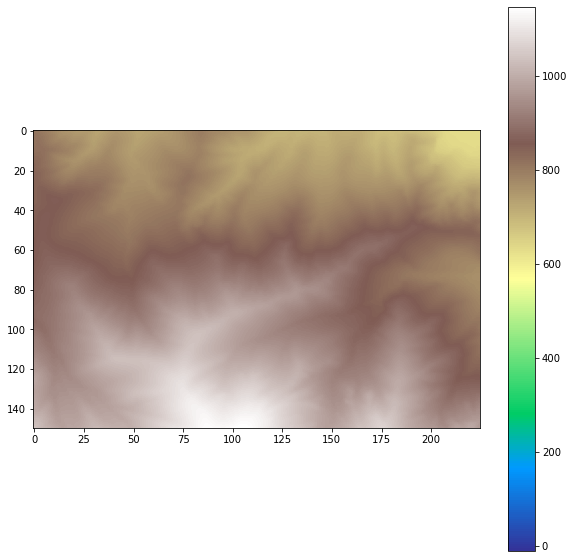

In [30]:
plt.figure(figsize = (10, 10))
im = plt.imshow(demp, cmap = "terrain",vmin = -10)
plt.colorbar(im)
plt.show()

# DEMをGeoTiffで保存する



GeoTiffで保存するためにはgdalライブラリを使います．
まず，DEMのアフィンパラメーターを用意します．
アフィンパラメーターは6個の実数のリストになります．
1個めはDEM全体の左側の座標，
2個めは標高値ひとつあたりの横方向のサイズ，
3個めは0で固定，
4個目はDEM全体の上側の座標，
5個目は0で固定，
6個目は標高値ひとつあたりの縦方向のサイズです．

DEM全体の左側の座標は，`df['lon']`の最小値（西の端），
標高値ひとつあたりの横方向のサイズは`Xsize`，
DEM全体の上側の座標は`df['lat']`の最大値（北の端），
標高値ひとつあたりの縦方向のサイズは`Ysize`になります．
ただし，標高値ひとつあたりの縦方向のサイズは南方向になるので負になります．

これらのパラメーターをリスト化し`trans`に格納します．


In [31]:
trans = [min(df['lon']), Xsize, 0, max(df['lat']), 0, -Ysize]
trans

[138.875, 5.555555555550503e-05, 0, 35.508333333, 0, -5.555555333335368e-05]

次にDEMの座標系を指定します．
GeoTiffで保存するためには，空間参照系を表すオブジェクト`osr.SpatialRefernece()`を作成し，
これにEPSGコードで空間参照系を設定します．
基盤地図情報のDEMはJGD2011の緯度経度座標系（地理座標系）で，
EPSGが`4612`になりますので，以下のような設定になります．


In [32]:
srs = osr.SpatialReference()
srs.ImportFromEPSG(4612)

0

次に書き出しの設定をします．
GeoTiffで保存するためには`gdal.GetDriverByName`型のオブジェクトを作り，
ここでファイル形式を指定します．
次に`Create`メソッドを使ってファイルを生成します．
`Create`メソッドの引数は，保存ファイル名，画像の縦サイズ，画像の横サイズ，バンド数，格納する配列の型です．

縦横サイズは`demp.shape`で取得できます．
`demp.shape[1]`が縦サイズ，`demp.shape[0]`が横サイズです．
バンド数はDEMが一つだけなので`1`です．
配列`demp`を保存しますので，データ型は32ビット浮動小数点型になります．

In [33]:
driver = gdal.GetDriverByName('GTiff')
output = driver.Create(base_dir + 'test.tif', demp.shape[1], demp.shape[0], 1, gdal.GDT_Float32)

標高の配列，設定した参照座標系などをオブジェクトに書き込みます．
また，データなしの値を`-9999`に設定します．

In [34]:
output.GetRasterBand(1).WriteArray(demp)
output.GetRasterBand(1).SetNoDataValue(-9999)
output.SetGeoTransform(trans)
output.SetProjection(srs.ExportToWkt())

0

最後にキャッシュをすべて書き出し，オブジェクトを削除して終了です．


In [35]:
output.FlushCache()
output = None

# 作成したDEMの投影変換



保存したGeoTiffは緯度経度座標系なので，
平面直角座標系に投影変換をします．
`gdal.Warp`を使えば投影変換ができます．

以下を試して見てください．

In [ ]:
opt = gdal.WarpOptions(dstSRS = 'EPSG:6677', srcNodata = -9999, dstNodata = -9999, outputType=gdal.GDT_Float32, xRes = 5.0, yRes = 5.0, resampleAlg = 'bilinear')
demnew = gdal.Warp(base_dir + 'miyake_dem_JGD2011_reprojected.tif', base_dir + 'miyake_dem_JGD2011_latlon.tif', options = opt)
demnew.FlushCache()
denew = None


# 全部入りのプログラム


以下が全部入りのプログラムです．
ディレクトリ内にあるすべての基盤地図情報DEMのXMLファイルを自動的に読み込み，
つなぎ合わせてGeoTiffで書き出します．

ディレクトリ内のすべてのXMLファイルを処理する部分では，
`glob`とループで逐次処理を行っています．
ファイルごとに縦持ちの標高データ`df`を作成しそれを`dfall`に追加することで，
処理対象のXMLから取得したすべての標高値を`dfall`に格納しています．
最後に`dfall`を横持ちに変換することで
ファイルの結合をしています．


100%|██████████| 100/100 [00:06<00:00, 15.64it/s]


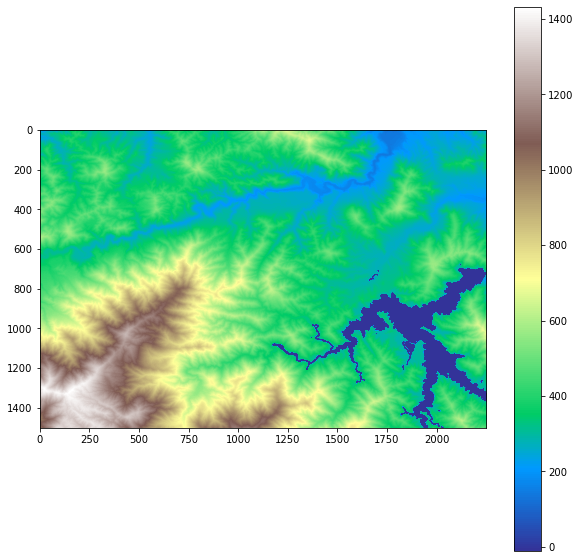

In [5]:
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import glob
import pandas as pd
import io
from tqdm import tqdm
import time
from osgeo import gdal, gdalconst, gdal_array, osr
#from google.colab import drive

#drive.mount('/content/drive')
base_dir = "./"

ns = {'default': 'http://fgd.gsi.go.jp/spec/2008/FGD_GMLSchema',
  'xlink': 'http://www.w3.org/1999/xlink',
  'xsi': 'http://www.w3.org/2001/XMLSchema-instance',
  'gml': 'http://www.opengis.net/gml/3.2'}

infiles = glob.glob(base_dir + '/GSI-DEM2/*.xml')

dfall = pd.DataFrame()

# ここからループしてすべてのXMLファイルを変換する

for infile in tqdm(infiles):
  tree = ET.parse(infile)
  elem = tree.getroot()

  lowercorner = elem.find('.//gml:lowerCorner', ns)
  uppercorner = elem.find('.//gml:upperCorner', ns)

  tuplelist = elem.find(".//gml:tupleList", ns)
  df = pd.read_csv(io.StringIO(tuplelist.text), header = None)
  df.columns = ['att', 'z']

  startPoint = elem.find('.//gml:startPoint', ns).text.split(' ')
  startPointX = int(startPoint[0])
  startPointY = int(startPoint[1])

  cols = int(elem.find(".//gml:high", ns).text.split(' ')[0]) + 1
  rows = int(elem.find(".//gml:high", ns).text.split(' ')[1]) + 1

  start = startPointX + (cols * startPointY)
  end = int(df.shape[0]) + start

  df['n'] = list(range(start, end))
  df['x4'] = (df['n'] % cols)
  df['y4'] = (df['n'] // cols)

  uppercorner = elem.find('.//gml:upperCorner', ns)
  lowercorner = elem.find('.//gml:lowerCorner', ns)

  ULX = float(lowercorner.text.split(' ')[1])
  ULY = float(uppercorner.text.split(' ')[0])
  LRX = float(uppercorner.text.split(' ')[1])
  LRY = float(lowercorner.text.split(' ')[0])

  mesh = elem.find('.//default:mesh', ns)
  
  df['y1'] = int(mesh.text[0:2])
  df['x1'] = int(mesh.text[2:4])
  df['y2'] = int(mesh.text[4])
  df['x2'] = int(mesh.text[5])
  df['y3'] = int(mesh.text[6])
  df['x3'] = int(mesh.text[7])

  df['x'] = df['x4'] + (df['x3'] * cols) + (df['x2'] * 10 * cols) + (df['x1'] * 8 * 10 * cols)
  df['y'] = df['y4'] + ((8 - df['y3']) * rows) + ((10 - df['y2']) * 10 * rows) + ((100 - df['y1']) * 8 * 10 * rows)

  Xsize = (LRX - ULX) / cols
  Ysize = (ULY - LRY) / rows

  df['lon'] = ULX + df['x4'] * Xsize
  df['lat'] = ULY - df['y4'] * Ysize

#  dfall = dfall.append(df)
  dfall = pd.concat([dfall, df])

# データがない部分用のダミーデータを作る
d1 = pd.DataFrame()
d2 = pd.DataFrame()

d1['x'] = list(range(min(dfall['x']), max(dfall['x'])))
d1['y'] = min(dfall['y'])
d1['z'] = -9999
d2['x'] = min(dfall['x'])
d2['y'] = list(range(min(dfall['y']), max(dfall['y'])))
d2['z'] = -9999

# ダミーデータを標高の入っているデータフレームに結合する
#dfall = dfall.append(d1).append(d2)
dfall = pd.concat([dfall, d1, d2])

# 縦持ちデータを横持ちにピボットする
# データなしと標高値が重なる場合があるので，その場合は最大値（すなわち標高値）を残す
dem = dfall.pivot_table(index = 'y', columns = 'x', values = 'z', fill_value = -9999, aggfunc = 'max')
dem = dem.sort_index()

# 横持ちにした標高値を32ビット浮動小数点型のnp.Arrayに変換する
demp = dem.values.astype(np.float32)

# 確認のためDEMを図化する
plt.figure(figsize = (10, 10))
im = plt.imshow(demp, cmap = "terrain",vmin = -10)
plt.colorbar(im)
plt.show()

# GeoTiff書き出しのためのアフィンパラメータの設定（北西端の座標，メッシュサイズなど）
trans = [min(dfall['lon']), Xsize, 0, max(dfall['lat']), 0, -Ysize]

# 座標系の設定（EPSG:4612，JGD2000の緯度経度座標系）
srs = osr.SpatialReference()
srs.ImportFromEPSG(4612)

# GeoTiff書き出しのための準備，オブジェクトの生成と初期化
driver = gdal.GetDriverByName('GTiff')
output = driver.Create(base_dir + 'tanzawa_dem_JGD2011_latlon.tif', demp.shape[1], demp.shape[0], 1, gdal.GDT_Float32)
output.GetRasterBand(1).WriteArray(demp)
output.GetRasterBand(1).SetNoDataValue(-9999)
output.SetGeoTransform(trans)
output.SetProjection(srs.ExportToWkt())
output.FlushCache()
output = None

# DEMをEPSG:6677（JGD2011第9系）に投影変換して保存する
opt = gdal.WarpOptions(dstSRS = 'EPSG:6677', srcNodata = -9999, dstNodata = -9999, outputType=gdal.GDT_Float32, xRes = 5.0, yRes = 5.0, resampleAlg = 'bilinear')
demnew = gdal.Warp(base_dir + 'tanzawa_dem_JGD2011_reprojected.tif', base_dir + 'tanzawa_dem_JGD2011_latlon.tif', options = opt)
demnew.FlushCache()
denew = None
